<a href="https://colab.research.google.com/github/carlomigs/Codemaster/blob/master/Carlo_Miguel_Gonzalez_Sr_Mgr_Global_Ops_Analytics_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This case study is authored by Carlo Miguel Gonzalez as part of the application requirements for the Sr. Mg. Global Operations Analytics post at Tala and created using Google Colaboratory which is an online, secure, and private compute host for Jupyter Notebooks.

It integrates with Google Drive to reference file-based data sources and as a repository of the Notebook itself. The analysis may be rerun on new data, with minimal to no change, provided the original Excel sheet names and column headers are retained.

**Install frameworks and Import data**

In [1]:
# Install frameworks which supports use of SQL in Python and FBProphet forecasting library
!pip install pandasql
!pip install SQLAlchemy==1.4.46 # bugfix to get pandasql to work properly
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import library dependencies into Python
from pandasql import sqldf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from google.colab import drive
import datetime as datetime
from prophet import Prophet

# Mount Google Drive to access Excel file location
drive.mount('/content/drive/')

# Custom function to simplify sqldf function calls
pysqldf = lambda q: sqldf(q, globals())

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Read Excel file
dict_df = pd.read_excel('/content/drive/My Drive/Tala Case Study Dataset (2).xlsx',
                        sheet_name = ['calls', 'disposition', 'nonpay_reason',
                                      'payment', 'historical_volume'])

# Break out sheet contents into individual dataframes
calls_df = dict_df.get('calls')
disposition_df = dict_df.get('disposition')
nonpayReason_df = dict_df.get('nonpay_reason')
payment_df = dict_df.get('payment')
historicalVolume_df = dict_df.get('historical_volume')

In [4]:
# Test query joins and verify record count
query = '''
    SELECT cd.*, dd.disposition_name, nd.nonpay_reason_name, pd.amount_paid
    FROM calls_df cd
    LEFT JOIN disposition_df dd ON cd.disposition_id = dd.disposition_id
    LEFT JOIN nonpayReason_df nd ON cd.nonpay_reason_id = nd.nonpay_reason_id
    LEFT JOIN payment_df pd ON cd.call_id = pd.call_id
    ORDER BY cd.call_id
    '''
print(pysqldf(query).shape[0], 'records imported from Excel.')

3808 records imported from Excel.




---



**Descriptive and Diagnostic Analysis**


> 1. How successful were our calls at connecting?

In [5]:
callCountQuery = '''
    select count(1) as successCount
    from calls_df
    '''

successCallCountQuery = '''
    select count(1) as successCount
    from calls_df cd
    left join disposition_df dd on cd.disposition_id = dd.disposition_id
    where dd.disposition_name in ("Right Party Contacted",
                                  "3rd Party Contacted",
                                  "Dispute",
                                  "Hang Up")
    '''

# Execute queries, extract result out of dataframe, and assign to variable
callCount = pysqldf(callCountQuery).values[0][0]
successCallCount = pysqldf(successCallCountQuery).values[0][0]
successRate = successCallCount / callCount

print('Our Calls are', "{0:.2%}".format(successRate), 'successful at connecting (',
      successCallCount, 'out of', callCount, 'calls connected).\n',
      'This assumes having anyone answer the call, including "Hang Ups", as a successful "connection",\n',
      'regardless of whether or not we were able to collect a payment or PTP,\n'
      ' and does not exclude multiple calls to the same LOAN_ID.')

Our Calls are 75.58% successful at connecting ( 2878 out of 3808 calls connected).
 This assumes having anyone answer the call, including "Hang Ups", as a successful "connection",
 regardless of whether or not we were able to collect a payment or PTP,
 and does not exclude multiple calls to the same LOAN_ID.


> 2. Why do calls fail?

In [6]:
nonpayReasonQuery = '''select
    ifnull(dd.disposition_name, 'NULL') || '_' || ifnull(nd.nonpay_reason_name, 'NULL') as dispositionNonpayReason,
    ifnull(dd.disposition_name, 'NULL') as disposition_name,
    ifnull(nd.nonpay_reason_name, 'NULL') as nonpay_reason_name,
    --count(1) as count,
    --sum(case when pd.amount_paid > 0 then 1 else 0 end) paidCount,
    --sum(case when pd.amount_paid > 0 then 0 else 1 end) notPaidCount,
    --sum(case when cd.ptp_amount > 0 then 0 else 1 end) notPTPCount,
    sum(case when (pd.amount_paid > 0 and cd.ptp_amount > 0) then 0 else 1 end) as notPaidOrPTPCount
    from calls_df cd
    left join disposition_df dd on cd.disposition_id = dd.disposition_id
    left join nonpayReason_df nd on cd.nonpay_reason_id = nd.nonpay_reason_id
    left join payment_df pd on cd.call_id = pd.call_id
    where ((pd.amount_paid = 0 or pd.amount_paid is null) and (cd.ptp_amount = 0 or cd.ptp_amount is null))
    group by dd.disposition_name, nd.nonpay_reason_name
    order by sum(case when (pd.amount_paid > 0 and cd.ptp_amount > 0) then 0 else 1 end) desc
    '''

# Execute query, add Cumulative Percent column
nonpayReasons = pysqldf(nonpayReasonQuery)
nonpayReasons['cumPerc'] = nonpayReasons['notPaidOrPTPCount'].cumsum() / nonpayReasons['notPaidOrPTPCount'].sum()*100

print('Call Failure, denoted by a failure to collect payments or get a PTP on any call,\n',
    'can be broken down by the Disposition Name and the Nonpay Reasons below:\n')
print(nonpayReasons[['disposition_name', 'nonpay_reason_name', 'notPaidOrPTPCount', 'cumPerc']].to_string(index=False))

Call Failure, denoted by a failure to collect payments or get a PTP on any call,
 can be broken down by the Disposition Name and the Nonpay Reasons below:

     disposition_name          nonpay_reason_name  notPaidOrPTPCount    cumPerc
            No Answer                        NULL                921  39.939289
              Hang Up                        NULL                871  77.710321
  3rd Party Contacted                        NULL                425  96.140503
Right Party Contacted         Medical Emergencies                 34  97.614918
Right Party Contacted                        NULL                 14  98.222029
Right Party Contacted             Delay in Salary                 14  98.829141
              Dispute                        NULL                 12  99.349523
                 NULL                        NULL                  3  99.479618
Right Party Contacted                    Accident                  3  99.609714
Right Party Contacted                       

> 3. How well do our collectors capture PTPs?

In [7]:
PTPbyAgentIdQuery = '''
    select cd.agent_id, count(1) as callCount,
    sum(case when cd.ptp_amount > 0 then 1 else 0 end) as PTPCount
    from calls_df cd
    group by cd.agent_id
    '''

# Execute query, add PTP Capture Rate, and sort
PTPbyAgentId = pysqldf(PTPbyAgentIdQuery)
PTPbyAgentId['PTPCaptureRate'] = PTPbyAgentId['PTPCount'] / PTPbyAgentId['callCount'] * 100
PTPbyAgentId.sort_values(by='PTPCaptureRate', ascending=False, inplace=True)
print('We define a PTP Capture to be whether or not a PTP Amount is captured on an individual call.\n')
print(PTPbyAgentId[['AGENT_ID', 'PTPCount', 'callCount', 'PTPCaptureRate']].to_string(index=False))

We define a PTP Capture to be whether or not a PTP Amount is captured on an individual call.

 AGENT_ID  PTPCount  callCount  PTPCaptureRate
       10       157        360       43.611111
        3       163        374       43.582888
        1       158        396       39.898990
        5       142        356       39.887640
        7       147        372       39.516129
        2       154        395       38.987342
        4       146        379       38.522427
        9       149        397       37.531486
        6       148        404       36.633663
        8       137        375       36.533333


> 4. Who are our best collectors and why?

In [8]:
AmtPaidByAgentIdQuery = '''
    select cd.agent_id, count(1) as callCount,
    sum(case when pd.amount_paid > 0 then 1 else 0 end) as AmtPaidCount
    from calls_df cd
    left join payment_df pd on cd.call_id = pd.call_id
    group by cd.agent_id
    '''

# Execute query, add PTP Capture Rate, and sort
AmtPaidByAgentId = pysqldf(AmtPaidByAgentIdQuery)
AmtPaidByAgentId['collectionRate'] = AmtPaidByAgentId['AmtPaidCount'] / AmtPaidByAgentId['callCount'] * 100
AmtPaidByAgentId.sort_values(by='collectionRate', ascending=False, inplace=True)
print('We define a "collection" to be whether or not an Amount Paid is collected on an individual call.\n')
print(AmtPaidByAgentId[['AGENT_ID', 'AmtPaidCount', 'callCount', 'collectionRate']].to_string(index=False))

We define a "collection" to be whether or not an Amount Paid is collected on an individual call.

 AGENT_ID  AmtPaidCount  callCount  collectionRate
        3           126        374       33.689840
       10           113        360       31.388889
        5           102        356       28.651685
        1           111        396       28.030303
        9           110        397       27.707809
        6           108        404       26.732673
        7            95        372       25.537634
        4            95        379       25.065963
        2            99        395       25.063291
        8            92        375       24.533333


> 5. How successful are we at reaching Right Party Contacts vs. other types of disposition outcomes?

In [9]:
dispositionCountQuery = '''
    select dd.disposition_name, count(1) as dispositionCount
    from calls_df cd
    left join disposition_df dd on cd.disposition_id = dd.disposition_id
    group by dd.disposition_name
    '''

# Execute query, add in the callCount from item#1, derive the Disposition Percentage
dispositionCount = pysqldf(dispositionCountQuery)
dispositionCount['callCount'] = callCount
dispositionCount['dispositionPerc'] = dispositionCount['dispositionCount'] / dispositionCount['callCount'] * 100
dispositionCount.sort_values(by='dispositionPerc', ascending=False, inplace=True)

print('Percentage of each Disposition outcome relative to the total call count shown below:\n')
print(dispositionCount[['DISPOSITION_NAME', 'dispositionCount', 'callCount', 'dispositionPerc']].to_string(index=False))

Percentage of each Disposition outcome relative to the total call count shown below:

     DISPOSITION_NAME  dispositionCount  callCount  dispositionPerc
Right Party Contacted              1565       3808        41.097689
            No Answer               921       3808        24.185924
              Hang Up               871       3808        22.872899
  3rd Party Contacted               429       3808        11.265756
              Dispute                13       3808         0.341387
                 None                 8       3808         0.210084
                 Busy                 1       3808         0.026261




---



**Predictive and Prescriptive Analysis**
> 1. Identify 1-3 other critical team, system, and/or agent-level insights using given data.



In [10]:
print('''
1.   Approximately 40% of all Failed calls (No Amount Paid or PTP Amount) has a "No Answer" Disposition.
     This appears to be, in part, due to individual LOAN_IDs requiring multiple calls before a connection is made
     and further analysis may be warranted as the prospect of breaking repeat calls out
     (i.e.: through a separate callback team) may improve the accuracy of individual Agent metrics.\n
2.   There are 8 calls that doesn't have a Disposition. Although it is a small percentage of the total calls,
     it is also one of the first pieces of information that is captured and having it missing could indicate
     either a systematic or behavioral opportunity which could also have an impact on the accuracy of the other metrics.\n
3.   There are also a few items for consideration regarding the selection of Dispositions
     which could afford us more insights if addressed:
     a.   There does not appear to be a "Wrong Number" Disposition which could
          reflect on the accuracy of the information provided by the loan applicant
     b.   "Dispute" may make more sense as a Nonpayment Reason instead of a Disposition
     c.   There is one inconsistent Disposition - Nonpayment Reason pair ("Right Party Contacted - Death")
    ''')


1.   Approximately 40% of all Failed calls (No Amount Paid or PTP Amount) has a "No Answer" Disposition.
     This appears to be, in part, due to individual LOAN_IDs requiring multiple calls before a connection is made
     and further analysis may be warranted as the prospect of breaking repeat calls out
     (i.e.: through a separate callback team) may improve the accuracy of individual Agent metrics.

2.   There are 8 calls that doesn't have a Disposition. Although it is a small percentage of the total calls,
     it is also one of the first pieces of information that is captured and having it missing could indicate
     either a systematic or behavioral opportunity which could also have an impact on the accuracy of the other metrics.

3.   There are also a few items for consideration regarding the selection of Dispositions
     which could afford us more insights if addressed:
     a.   There does not appear to be a "Wrong Number" Disposition which could
          reflect on the a

> 2. Given existing data and context, provide prioritized areas of focus for team leads and managers of collections


Based on the "Reasons for Call Failure" from item#2 of the Analysis, we show that
over 96% of the Calls where we do not make a collection or acquire a PTP are due to
"No Answer", "Hang Up", and "3rd Party Contacted" Dispositions each of which, may
require further analysis and it's own unique plan of action.

Available data only currently covers less than two days of calls and it is
recommended to acquire more prior to establishing and analyzing hourly interval
and individual agent performance.
      


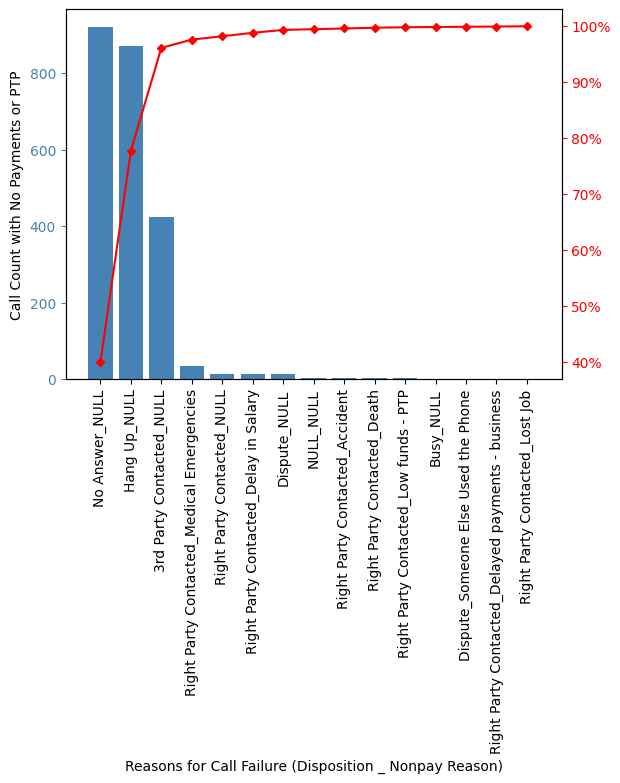

In [11]:
# Concatenate Disposition and Nonpay Reasons, and add cumulative percentage column
nonpayRsns = nonpayReasons[['dispositionNonpayReason', 'notPaidOrPTPCount', 'cumPerc']]
nonpayRsns.set_index('dispositionNonpayReason', inplace=True)

# Plot Pareto chart
fig, ax = plt.subplots()
ax.bar(nonpayRsns.index, nonpayRsns["notPaidOrPTPCount"], color="steelblue")
ax2 = ax.twinx()
ax2.plot(nonpayRsns.index, nonpayRsns["cumPerc"], color="red", marker="D", ms=4)
ax2.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis="y", colors="steelblue")
ax2.tick_params(axis="y", colors="red")
ax.tick_params(axis='x', labelrotation = 90)
ax.set_xlabel("Reasons for Call Failure (Disposition _ Nonpay Reason)")
ax.set_ylabel("Call Count with No Payments or PTP")

print('''
Based on the "Reasons for Call Failure" from item#2 of the Analysis, we show that
over 96% of the Calls where we do not make a collection or acquire a PTP are due to
"No Answer", "Hang Up", and "3rd Party Contacted" Dispositions each of which, may
require further analysis and it's own unique plan of action.\n
Available data only currently covers less than two days of calls and it is
recommended to acquire more prior to establishing and analyzing hourly interval
and individual agent performance.
      ''')
plt.show()

> 3. Using the available data historical_volume please provide your own forecasting and recommendation

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0j08z6n8/kf1ocb3p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0j08z6n8/1oho7vi8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47425', 'data', 'file=/tmp/tmp0j08z6n8/kf1ocb3p.json', 'init=/tmp/tmp0j08z6n8/1oho7vi8.json', 'output', 'file=/tmp/tmp0j08z6n8/prophet_model1u1ry4qk/prophet_model-20230619171514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Primary recommendation would be to acquire at least a year's worth of data to
allow the selected forecasting algorithm to establish a baseline for higher-period
seasonality (i.e. quarterly, yearly).
      


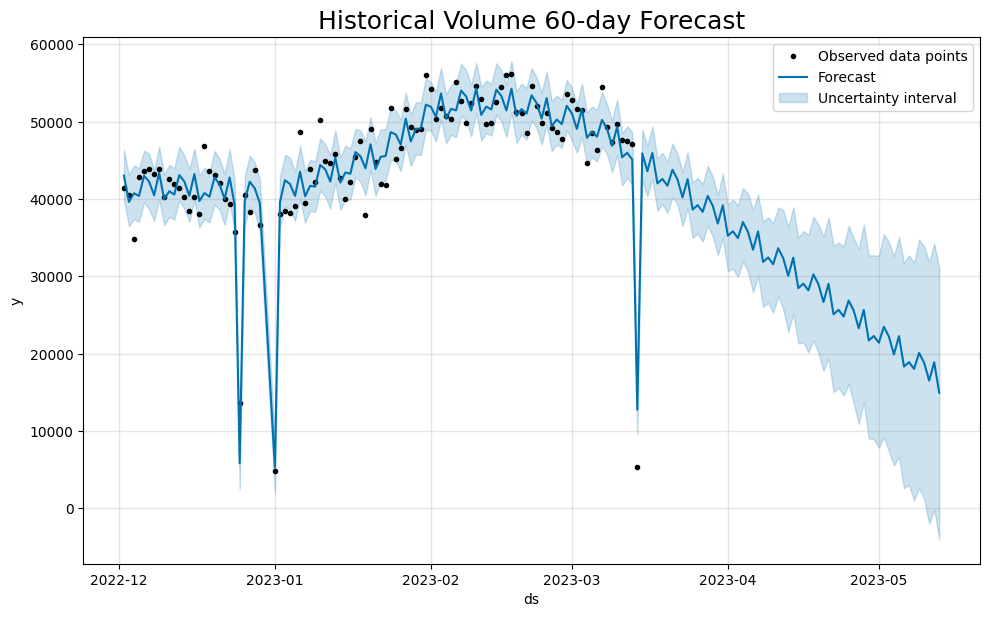

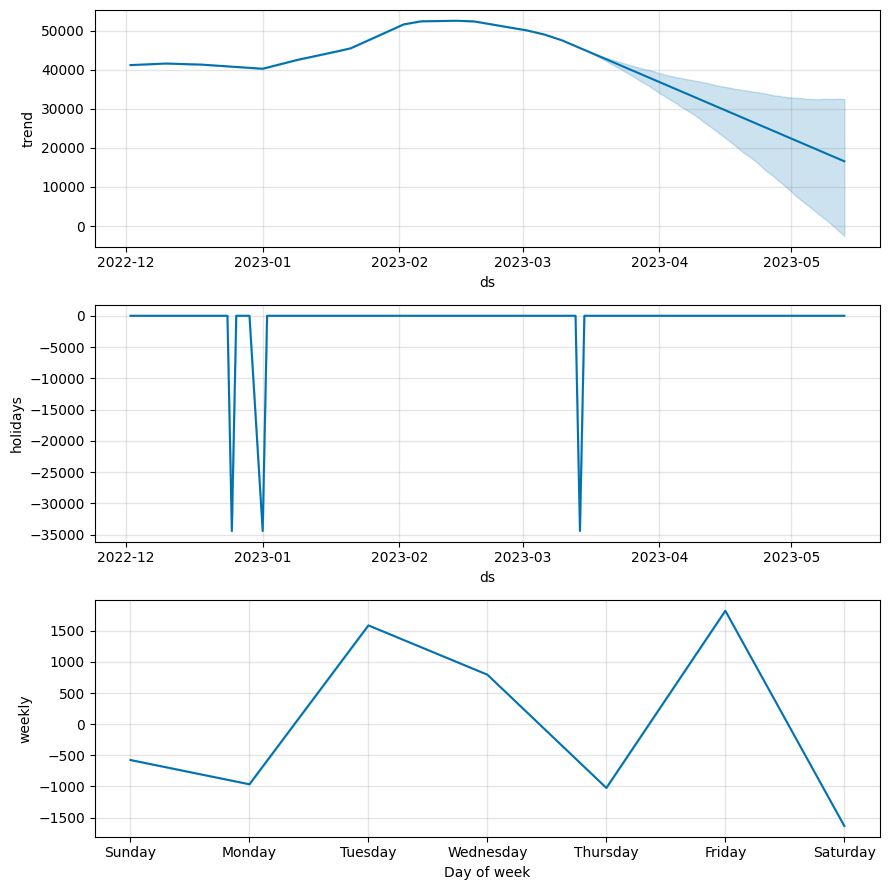

In [23]:
historicalVolumeQuery = '''
    select date, sum(volume) as volume
    from historicalVolume_df
    group by date
    '''

# Execute query
historicalVolume = pysqldf(historicalVolumeQuery)
df = pd.DataFrame()
df['ds'] = pd.to_datetime(historicalVolume['DATE'])
df['y'] = historicalVolume['volume']

# declare holidays
outlier = pd.DataFrame({
  'holiday': 'outlier',
  'ds': pd.to_datetime(['2023-01-01', '2023-03-14', '2022-12-25'])
})

# instantiate the model and fit the timeseries
m = Prophet(changepoint_prior_scale=0.75, holidays=outlier, changepoint_range=1)
# df.loc[(df['ds'] == '2023-03-14'), 'y'] = None # attempt to remove holiday manually
m.fit(df)

# create a future data frame
future = m.make_future_dataframe(periods=60, freq='D')
forecast = m.predict(future)

# plot
fig1 = m.plot(forecast, include_legend=True)
ax = fig1.gca()
ax.set_title('Historical Volume 60-day Forecast', size=18)
fig2 = m.plot_components(forecast)

print('''
Primary recommendation would be to acquire at least a year's worth of data to
allow the selected forecasting algorithm to establish a baseline for higher-period
seasonality (i.e. quarterly, yearly).
      ''')

> 4. 30-Day Daily Volume Forecast per type and per group.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0j08z6n8/v6wf08n5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0j08z6n8/kg3jqzrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38761', 'data', 'file=/tmp/tmp0j08z6n8/v6wf08n5.json', 'init=/tmp/tmp0j08z6n8/kg3jqzrc.json', 'output', 'file=/tmp/tmp0j08z6n8/prophet_modelvdsyx17x/prophet_model-20230619170514.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

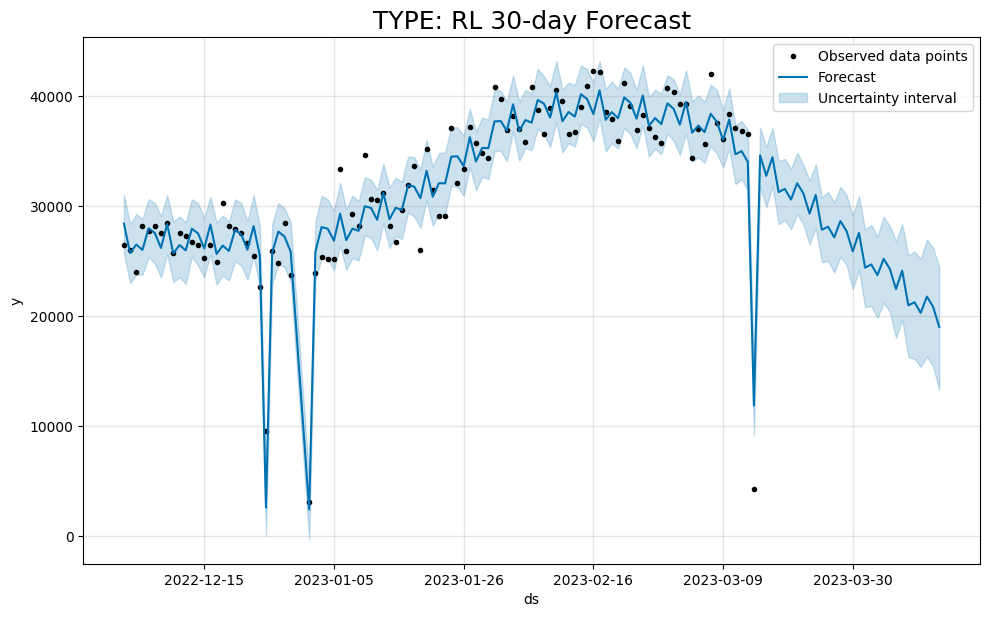

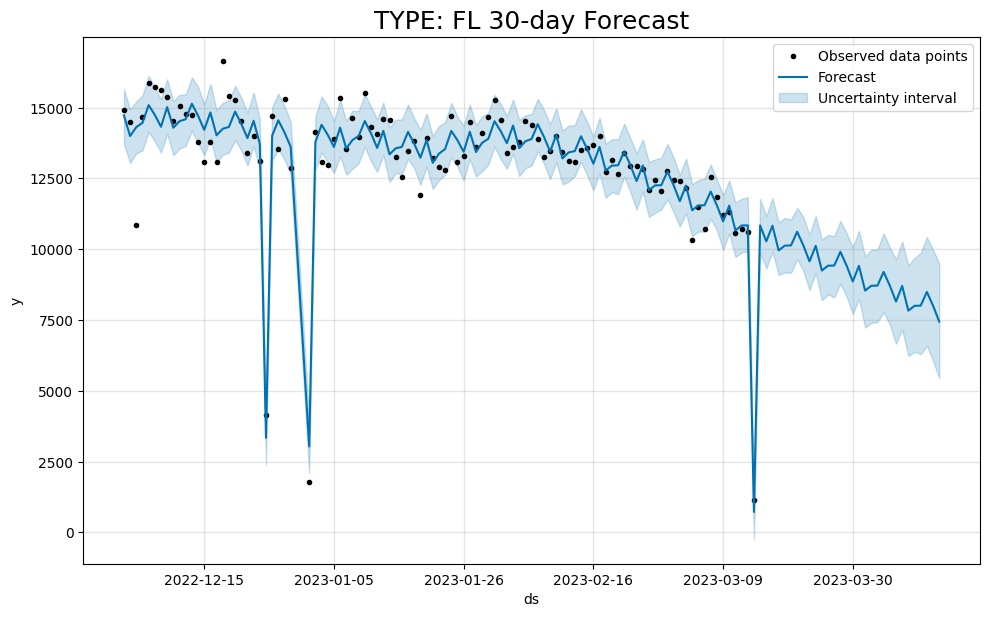

In [14]:
historicalVolumeQuery = '''
    select date, type, sum(volume) as volume
    from historicalVolume_df
    group by date, type
    '''

# Execute query
historicalVolume = pysqldf(historicalVolumeQuery)

for typ in ['RL', 'FL']:    # type list could be made dynamic
    filteredVolume = historicalVolume.query(str('TYPE =="' + typ + '"'))
    df = pd.DataFrame()
    df['ds'] = pd.to_datetime(filteredVolume['DATE'])
    df['y'] = filteredVolume['volume']

    # instantiate the model and fit the timeseries
    m = Prophet(changepoint_prior_scale=0.75, holidays=outlier, changepoint_range=1)
    m.fit(df)

    # create a future data frame
    future = m.make_future_dataframe(periods=30, freq='D')
    forecast = m.predict(future)

    # plot
    fig1 = m.plot(forecast, include_legend=True)
    ax = fig1.gca()
    ax.set_title('TYPE: ' + str(typ) + ' 30-day Forecast', size=18)
    # fig2 = m.plot_components(forecast, )

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0j08z6n8/81sfna3a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0j08z6n8/usjbolwv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74956', 'data', 'file=/tmp/tmp0j08z6n8/81sfna3a.json', 'init=/tmp/tmp0j08z6n8/usjbolwv.json', 'output', 'file=/tmp/tmp0j08z6n8/prophet_model0zzifwn6/prophet_model-20230619170516.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

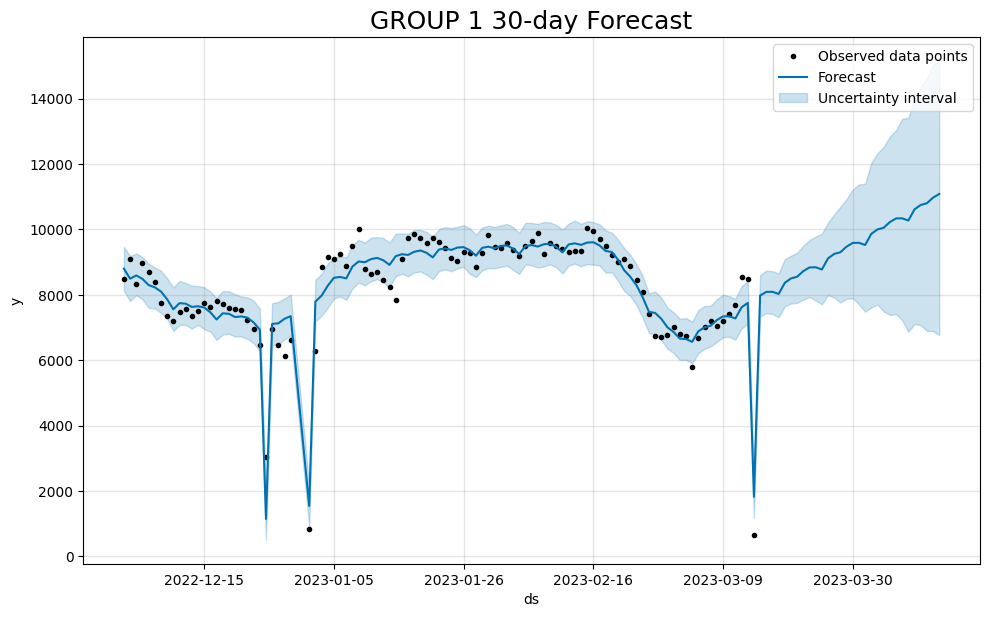

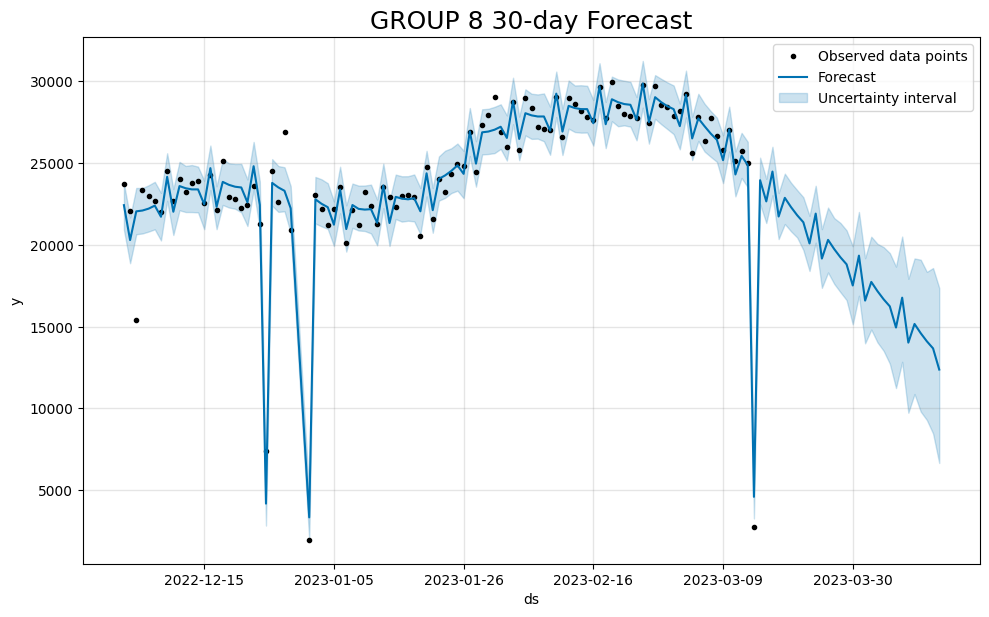

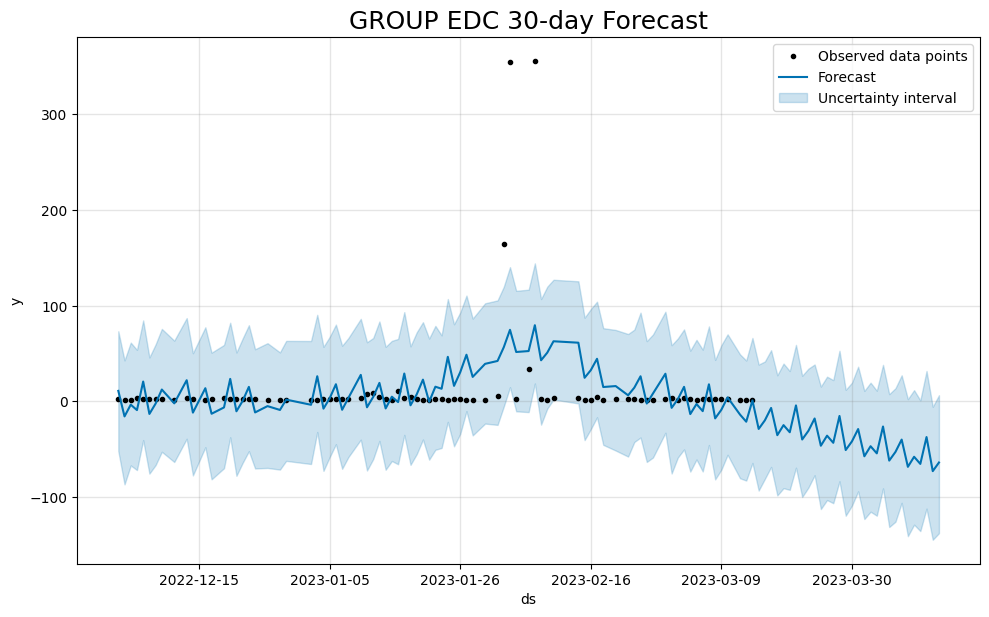

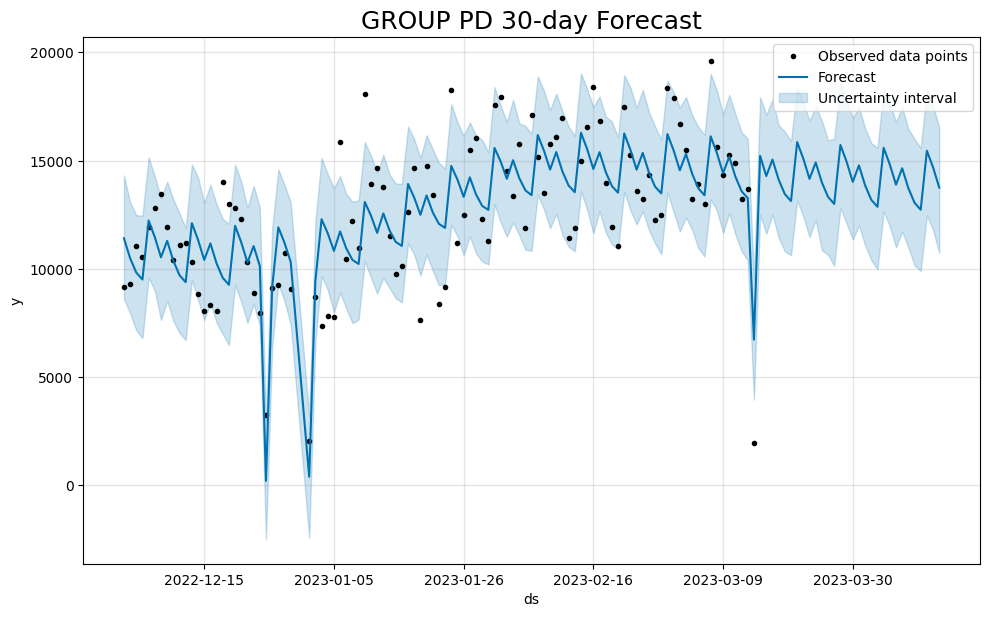

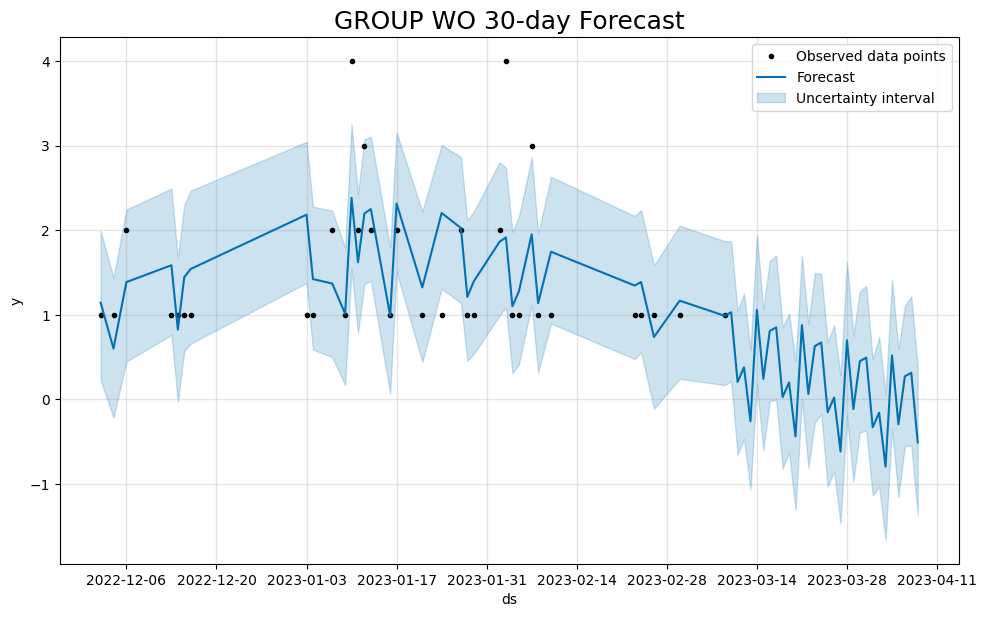

In [15]:
historicalVolumeQuery = '''
    select date, [group], sum(volume) as volume
    from historicalVolume_df
    group by date, [group]
    '''

# Execute query
historicalVolume = pysqldf(historicalVolumeQuery)

for grp in ['GROUP 1', 'GROUP 8', 'GROUP EDC', 'GROUP PD', 'GROUP WO']:    # group list could be made dynamic
    filteredVolume = historicalVolume.query(str('GROUP =="' + grp + '"'))
    df = pd.DataFrame()
    df['ds'] = pd.to_datetime(filteredVolume['DATE'])
    df['y'] = filteredVolume['volume']

    # instantiate the model and fit the timeseries
    m = Prophet(changepoint_prior_scale=0.75, holidays=outlier, changepoint_range=1)
    m.fit(df)

    # create a future data frame
    future = m.make_future_dataframe(periods=30, freq='D')
    forecast = m.predict(future)

    # plot
    fig1 = m.plot(forecast, include_legend=True)
    ax = fig1.gca()
    ax.set_title(str(grp) + ' 30-day Forecast', size=18)
    # fig2 = m.plot_components(forecast, )

> 5. 60-Day Daily Volume Forecast per type and per group.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0j08z6n8/4gab95py.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0j08z6n8/_t0k7o31.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48421', 'data', 'file=/tmp/tmp0j08z6n8/4gab95py.json', 'init=/tmp/tmp0j08z6n8/_t0k7o31.json', 'output', 'file=/tmp/tmp0j08z6n8/prophet_model8dw1a7ti/prophet_model-20230619170526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

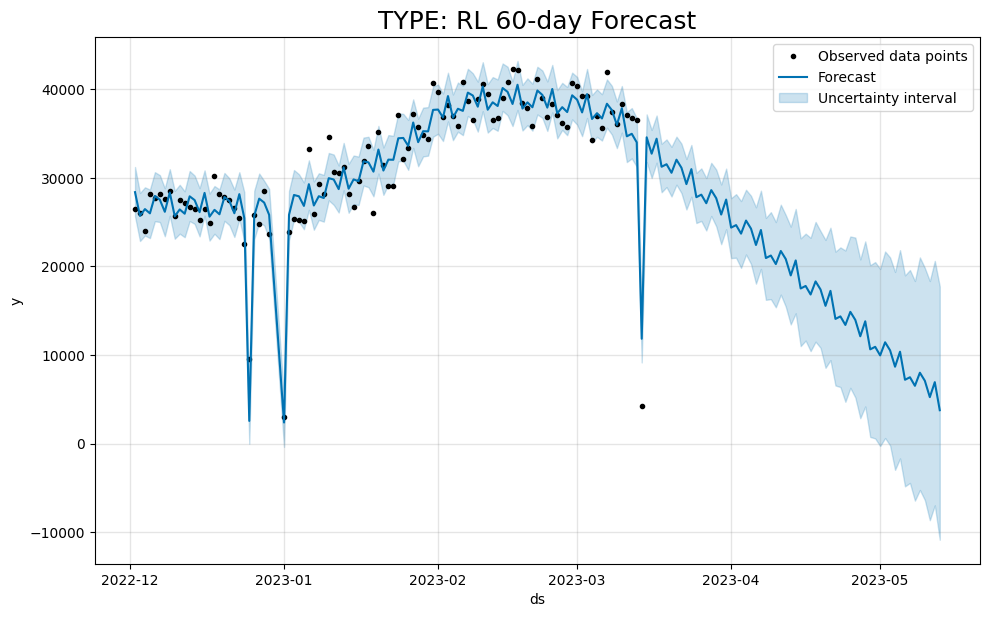

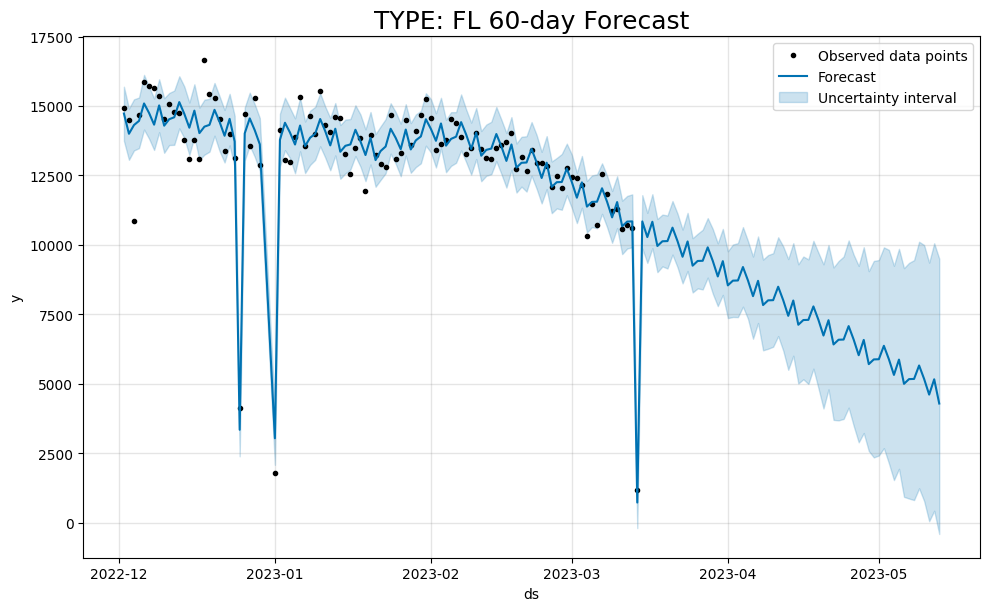

In [16]:
historicalVolumeQuery = '''
    select date, type, sum(volume) as volume
    from historicalVolume_df
    group by date, type
    '''

# Execute query
historicalVolume = pysqldf(historicalVolumeQuery)

for typ in ['RL', 'FL']:    # type list could be made dynamic
    filteredVolume = historicalVolume.query(str('TYPE =="' + typ + '"'))
    df = pd.DataFrame()
    df['ds'] = pd.to_datetime(filteredVolume['DATE'])
    df['y'] = filteredVolume['volume']

    # instantiate the model and fit the timeseries
    m = Prophet(changepoint_prior_scale=0.75, holidays=outlier, changepoint_range=1)
    m.fit(df)

    # create a future data frame
    future = m.make_future_dataframe(periods=60, freq='D')
    forecast = m.predict(future)

    # plot
    fig1 = m.plot(forecast, include_legend=True)
    ax = fig1.gca()
    ax.set_title('TYPE: ' + str(typ) + ' 60-day Forecast', size=18)
    # fig2 = m.plot_components(forecast, )

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0j08z6n8/z4bk3bdy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0j08z6n8/99o_c01r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73043', 'data', 'file=/tmp/tmp0j08z6n8/z4bk3bdy.json', 'init=/tmp/tmp0j08z6n8/99o_c01r.json', 'output', 'file=/tmp/tmp0j08z6n8/prophet_modelw6gcwyb2/prophet_model-20230619170530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

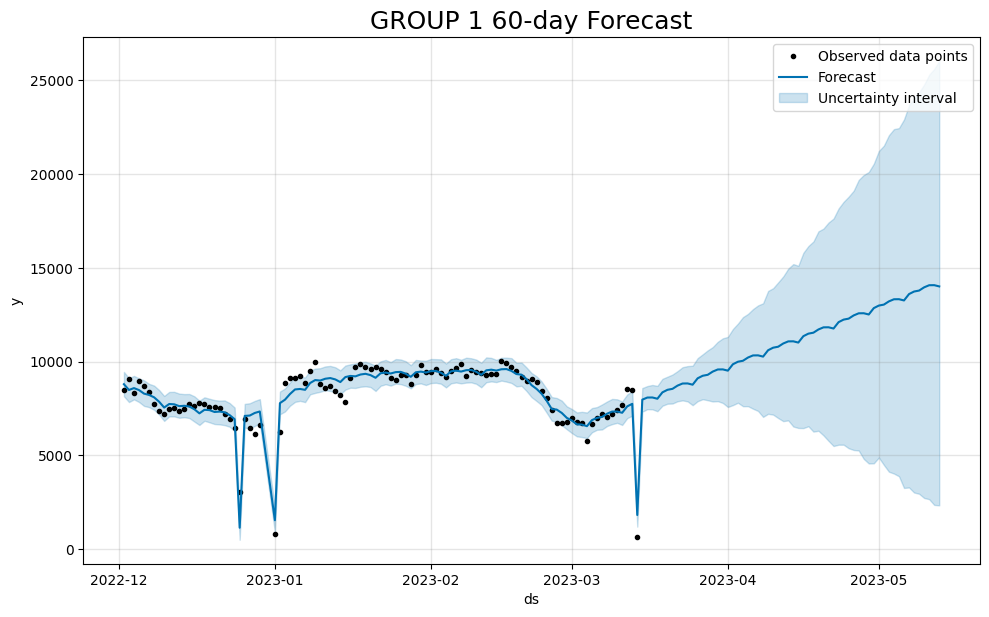

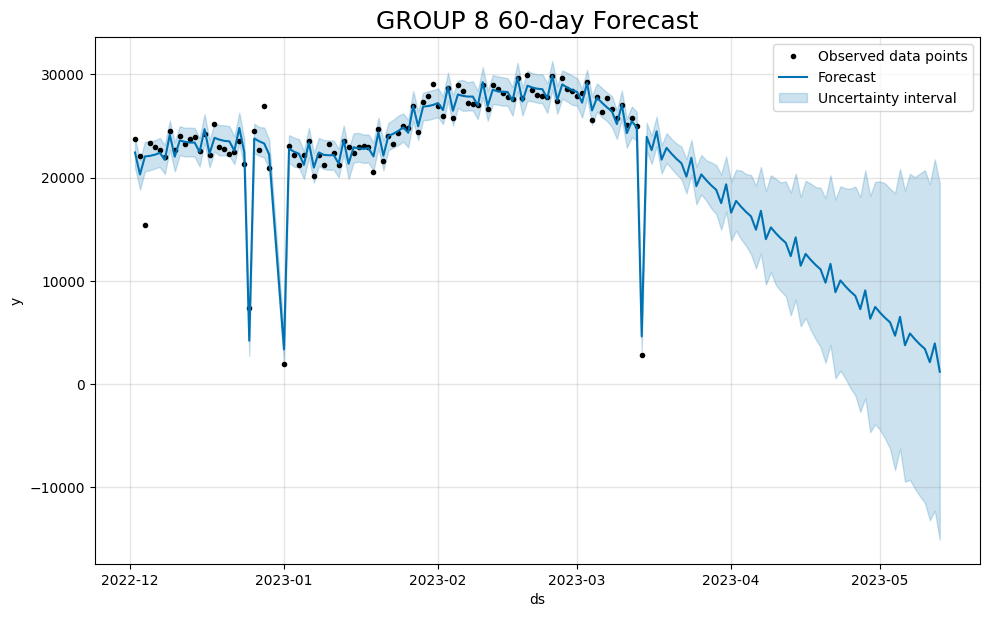

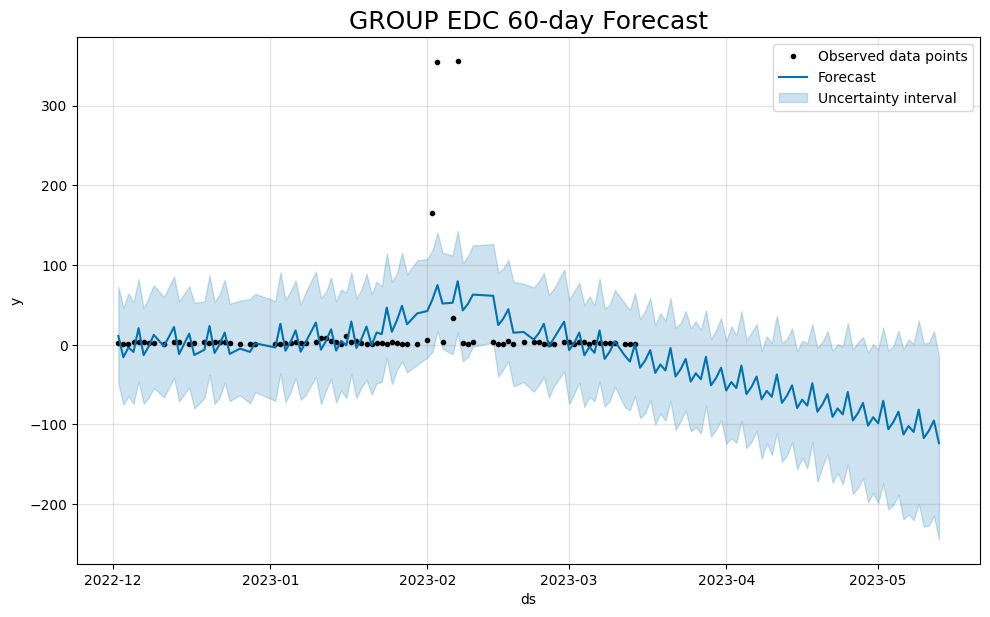

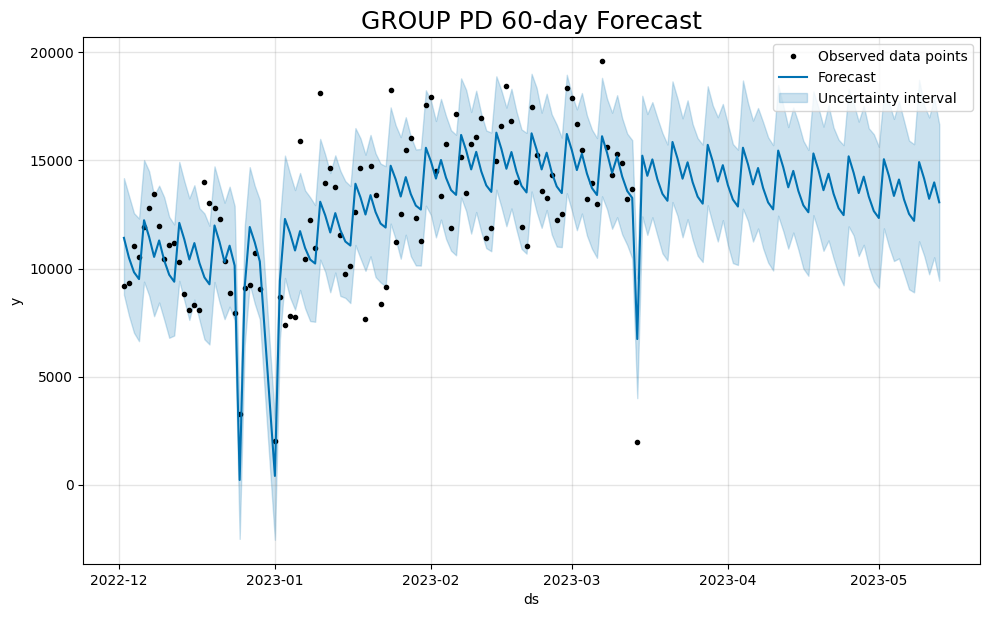

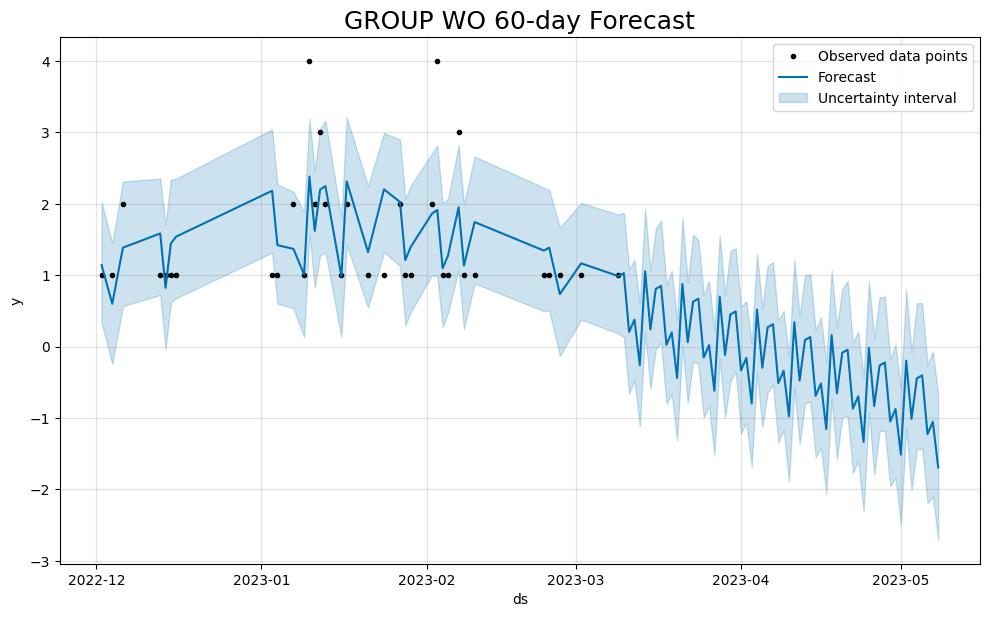

In [17]:
historicalVolumeQuery = '''
    select date, [group], sum(volume) as volume
    from historicalVolume_df
    group by date, [group]
    '''

# Execute query
historicalVolume = pysqldf(historicalVolumeQuery)

for grp in ['GROUP 1', 'GROUP 8', 'GROUP EDC', 'GROUP PD', 'GROUP WO']:    # group list could be made dynamic
    filteredVolume = historicalVolume.query(str('GROUP =="' + grp + '"'))
    df = pd.DataFrame()
    df['ds'] = pd.to_datetime(filteredVolume['DATE'])
    df['y'] = filteredVolume['volume']

    # instantiate the model and fit the timeseries
    m = Prophet(changepoint_prior_scale=0.75, holidays=outlier, changepoint_range=1)
    m.fit(df)

    # create a future data frame
    future = m.make_future_dataframe(periods=60, freq='D')
    forecast = m.predict(future)

    # plot
    fig1 = m.plot(forecast, include_legend=True)
    ax = fig1.gca()
    ax.set_title(str(grp) + ' 60-day Forecast', size=18)
    # fig2 = m.plot_components(forecast, )

> 6. Explain the forecasting methodology/algorithm that you used.

In [37]:
print('''
The open source Prophet software released by Facebook's Core Data Science team
has been utilized to create the 30 & 60-day volume forecasts.

The choice to use Prophet was necessitated by the need to account for the following
observations on the available data:
- The overall volume, as well as the volume per Type and per Group, exhibited
high variances from day-to-day (weekly seasonality).
- There is an overall trend which needed to be delineated from the weekly seasonality.
- There are extreme low-volume outliers which may be attributed to holidays.

While it may be possible to account for these observations manually by smoothening
the time series (i.e.: with a moving average) and utilizing curve-fitting methods
to determine the overall trend, aggregating and normalizing the series by day-of-week
and analyzing the weekly trend with week-on-week variance methods separately
(also monthly, quarterly, yearly if the data allows for it), and deleting extreme
outliers (so they don't impact the overall trend), all these methods are already
built into Prophet which significantly streamlines the entire process with just
a few function calls. Prophet exposes all the relevant hyperparameters so the
entire model can be fine-tuned as necessary.

Prophet is a procedure designed specifically for forecasting time series data
based on an additive mathematical model where non-linear trends are fit with yearly,
weekly, and daily seasonality, plus holiday effects. It is robust to missing data
and shifts in the trend, and typically handles outliers well. It does not require
significant compute resources and time to train (and retrain) like if we were to
use a Machine Learning model. All this makes it the perfect candidate for this
application!

We plotted the delineated trend and weekly seasonality of the overall data
only on item#3 of the Predictive & Prescriptive Analysis section (along with a
chart for holidays) to showcase them specifically but are already accounted for
in the individual plots for the volume forecasts per Type and per Group.
''')


The open source Prophet software released by Facebook's Core Data Science team
has been utilized to create the 30 & 60-day volume forecasts.

The choice to use Prophet was necessitated by the need to account for the following
observations on the available data:
- The overall volume, as well as the volume per Type and per Group, exhibited
high variances from day-to-day (weekly seasonality).
- There is an overall trend which needed to be delineated from the weekly seasonality.
- There are extreme low-volume outliers which may be attributed to holidays.

While it may be possible to account for these observations manually by smoothening
the time series (i.e.: with a moving average) and utilizing curve-fitting methods
to determine the overall trend, aggregating and normalizing the series by day-of-week
and analyzing the weekly trend with week-on-week variance methods separately
(also monthly, quarterly, yearly if the data allows for it), and deleting extreme
outliers (so they don't impact 

> 7. Explain the volume trend you identified from your forecast per group and per type

In [26]:
print('''
The volume trends per graph may be interpreted as follows:

item#3
      Historical Volume 60-day Forecast
    -   Forecast suggests we just started on a downtrend which could warrant further
      evaluation of the surrounding contexts (i.e.: Attrition Rate, Absenteeism).
      Even with limited data only covering about 3.5 months, we can see hints of
      a recovery and would recommend redoing the analysis with at least 2 years
      of data instead to more accurately reflect a quarterly/yearly trend and not
      end up understaffing once the higher timeframe seasonality kicks in. Our
      forecast does account for this possibility that we observe as the upper range
      of the uncertainty interval which curves upwards, against the forecasted trend.
        Weekly seasonality also indicates the lowest volume on Mondays & Thursdays
      which may be an opportunity to present additional incentives. The highest
      volumes come in on Tuesdays and Fridays.
        The sudden dips of the forecast line are intentional as this is how Prophet
      accounts for manually specified holidays. If we don't specify the holidays,
      it will impact the overall trend and seasonality albeit only minimally. The
      first two dips correspond to Christmas and the New Year, while the last one
      may be attributed to the data getting cut off abruptly at the end of the
      time series.

item#4/5
      Type: RL 30/60-day Forecast
    -   The only notable difference between the 30 & 60-day forecasts is that the
      uncertainty upper and lower levels continue to grow farther apart as it
      progresses. The overall trends continue linearly in the same direction.
      As such, we'll be interpretting both timeframes together. This should not
      be the case if we have more data which allows for the detection of distinct
      higher-period seasonality.
        Over 80% of the total volume is associated with the RL Call Type which makes
      the trend appear similar to the forecast for the overall data. Recommendations
      would be the same (redo the analysis with more data, investigate possible
      contexts driving the downtrend).

      Type: FL 30/60-day Forecast
    -   Observed data points suggest a continuous downtrend but acquiring more
      data would, as earlier, provide us with a better context. As it is, unless
      we're expecting to eventually retire this Call Type, further investigation
      may be warranted (i.e.: marketing efforts, accessibility of this Type from
      our application's UI).

      GROUP 1 30/60-day Forecast
    -   This group's volume trend is interesting in that it is visibly less
      predictable than all the other trends in this study. It appears to be impacted
      by systematic decisions (i.e.: putting a product offering on hold) or more
      pronounced higher period seasonality. Further investigation with more data
      around its context is also recommended. It could also benefit from further
      fine tuning of the Prophet hyperparameters to better fit the data. Specifically,
      a "logistic-growth" model may be more appropriate (instead of Prophet's
      default "piece-wise linear model"). This requires that we specify a minimum
      and maximum volume capacity which isn't currently available, however.

      GROUP 8 30/60-day Forecast
    -   Group's volume trend is similar to overall trend as well but with a
      considerable spike during Fridays (determined from weekly seasonality chart
      not included in this study but noticable from the forecast's trendline
      fluctuations) which suggests either most of the team is simply present on
      that day or everyone is making a break for it during the last day of the week
      to catch up on incentives.

      GROUP EDC 30/60-day Forecast
    -   The extremely low volume which only averages around 2-3 calls/day makes
      the forecast irrelevant for this group. There is an extreme spike in volume
      spread across 2 days (locally, but they could be associated with just one
      day if accounting using a different timezone). Assuming the Average Handle
      Time is roughly the same for all Call Types, this group may be associated
      with a new hire training team where everyone just watches one individual make
      calls until that one day where everyone has to try it altogether.

      GROUP PD 30/60-day Forecast
    -   Call volume varies drastically from day-to-day by up to 30%, with the highest
      volumes on Mondays and winding down as the week progresses. This suggests
      that agents may go through a lot of "No Answer" calls at the start of the
      week and eventually make a connection later on, or a list of LOAN_IDs to be
      processed are provided early in the week and the agents have the rest of the
      week to close everything out. Forecast appears that it could benefit from
      further hyperparameter tuning to better model the wide volume fluctuations.

      GROUP WO 30/60-day Forecast
    -   Similar to group EDC in that it has extremely low volume and inapplicable
      forecast, but this one doesn't have any large spikes which suggests this
      queue may be used sparingly, possibly by support teams (QA) or Supervisors
      who only occassionally makes calls to maintain their edge.
      ''')


The volume trends per graph may be interpreted as follows:

item#3
      Historical Volume 60-day Forecast
    -   Forecast suggests we just started on a downtrend which could warrant further
      evaluation of the surrounding contexts (i.e.: Attrition Rate, Absenteeism).
      Even with limited data only covering about 3.5 months, we can see hints of
      a recovery and would recommend redoing the analysis with at least 2 years
      of data instead to more accurately reflect a quarterly/yearly trend and not
      end up understaffing once the higher timeframe seasonality kicks in. Our 
      forecast does account for this possibility that we observe as the upper range
      of the uncertainty interval which curves upwards, against the forecasted trend.
        Weekly seasonality also indicates the lowest volume on Mondays & Thursdays
      which may be an opportunity to present additional incentives. The highest
      volumes come in on Tuesdays and Fridays.
        The sudden dip

> 8. How would you strategize your collection approach based on your forecast.

In [36]:
print('''
The following action items would be raised for consideration to address the
perceived overall downtrend:

- Review how calls to the same LOAN_ID / repeat calls are tracked and make provisions to not
inflate same-day call volume. Reassigning repeat calls to a specific Group which,
although won't eliminate uncontrollables from Collection / PTP Capture Rates entirely,
would significantly improve agent performance metrics and could also have a positive
impact on morale.

- Distribute LOAN_IDs / call lists more evenly throughout the week, especially
for Group PD to smoothen out their weekly seasonality.

- Re-evaluate call volume capacity, especially around the holiday months. We may
encourage agents to take their earned vacation leaves earlier in the year to minimize
extended periods of above-average shrinkage.

- Roll out more incentives / increase awareness of Performance Improvement Plans
as soon as we detect the start of a downtrend in overall call volume to minimize
its financial impact.
      ''')


The following action items would be raised for consideration to address the
perceived overall downtrend:

- Review how calls to the same LOAN_ID / repeat calls are tracked and make provisions to not
inflate same-day call volume. Reassigning repeat calls to a specific Group which,
although won't eliminate uncontrollables from Collection / PTP Capture Rates entirely,
would significantly improve agent performance metrics and could also have a positive
impact on morale.

- Distribute LOAN_IDs / call lists more evenly throughout the week, especially
for Group PD to smoothen out their weekly seasonality.

- Re-evaluate call volume capacity, especially around the holiday months. We may
encourage agents to take their earned vacation leaves earlier in the year to minimize
extended periods of above-average shrinkage.

- Roll out more incentives / increase awareness of Performance Improvement Plans
as soon as we detect the start of a downtrend in overall call volume to minimize
its financial imp

> 9. Overall Strategy

In [47]:
print('''
a. Collections Target Setting
        Assuming a wide variance in Collection / PTP Capture rates, we can evaluate
    overall performance as a Normal Distributon and select a value arbitrarily
    between the mean and one standard deviation below it as a reasonalbe initial
    target.
        This ensures about 80% of the agents would pass the target, which
    we can increase accordingly alongside step-goals designed with additional
    training / support / resources in mind.

b. Staffing Recommendation
        Inclusive staffing decisions would need to take into account the max volume
    capacity, and average call handling time per call type. This is especially
    important in outbound call queues where there are multiple opportunities for
    gaming the system. If we only have the provided call volume to work with,
    smoothening out the weekly seasonality would be a priority.
        Assuming everybody has the weekends off, our only other controllable are
    the leaves and efforts to prevent shrinkage (lates, absences). Else, we can
    spread out the days-off accordingly.

c. Performance Metrics and KPIs per team/agent
        In addition to the Collection and PTP Capture rates required from this
    analysis, the Average Handle Time (AHT) is a very important measure of agent
    productivity in Call queues. Being able to analyze time spent in auxillary
    queues (i.e.: After Call Work, Hold Time, Break, Case Research, etc..), would
    provide a lot of insight into agent behavior and opportunities for coaching.
        Quality Assurance (QA) scores, as evaluated by Supervisors and/or QA
    Analysts who listen to call recordings, are also essential in ensuring that
    the agents adhere to recommended high-converting call flows, and ethical/legal
    collection practices.
        At the team level, the mean of the agent metrics, in addition to minimal
    shrinkage and attrition, would be a good reflection of the Supervisor's
    performance.

d. Incentives for:
    i. Customer
        Providing allowable, and "time-sensitie" discounts to expedite Payment
    Collection could be mutually beneficial to customers and agents alike.
    Having a pseudo-"credit score" for customers who regularly settle their
    accounts on time and offering higher loanable amounts and extended payment
    terms are finance industry standards that may also be applicable in our
    setting.

    ii. Collections Agents
        While monetary incentives for exemplary performance have been instituted
    in many industries for some time, garnering points that counts toward a bidding
    or a straight up exchange of most requested items is not something we often
    witness due to the additional logistics required. But having redeemable
    awards catalogues on the corporate intranet and stacks of prizes on the
    production floor should be a welcome visual reminder.
      ''')


a. Collections Target Setting
        Assuming a wide variance in Collection / PTP Capture rates, we can evaluate
    overall performance as a Normal Distributon and select a value arbitrarily
    between the mean and one standard deviation below it as a reasonalbe initial
    target. 
        This ensures about 80% of the agents would pass the target, which
    we can increase accordingly alongside step-goals designed with additional
    training / support / resources in mind.

b. Staffing Recommendation
        Inclusive staffing decisions would need to take into account the max volume
    capacity, and average call handling time per call type. This is especially
    important in outbound call queues where there are multiple opportunities for
    gaming the system. If we only have the provided call volume to work with,
    smoothening out the weekly seasonality would be a priority. 
        Assuming everybody has the weekends off, our only other controllable are
    the leaves and e